## Introduction

This script demonstrates how you can use a RNN-based model to detect anomalies in timeseries data.

## Setup

In [1]:
import os
import random

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

from evaluator import evaluate, compute_threshold
from dataloader import loader


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

2023-03-22 20:15:18.995095: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


# Load the data

In [2]:
df_train, df_test, df_test_label = loader(dataset="UCR")

## Prepare training data


In [3]:
# Skip data normalization because SMAP datas were already normalized.
df_train = df_train.fillna(method="ffill")
scaler = StandardScaler()
scaler.fit(df_train)
df_training_value = pd.DataFrame(scaler.transform(df_train))
df_test_value = pd.DataFrame(scaler.transform(df_test))
print("Number of training samples:", len(df_training_value))
print("Number of training samples:", len(df_test_value))

Number of training samples: 35000
Number of training samples: 44795


### Create sequences
Create sequences combining `TIME_STEPS` contiguous data values from the
training data.

In [4]:
TIME_STEPS = 100


# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

Training input shape:  (34901, 100, 1)
Test input shape:  (44696, 100, 1)


## Build a model


In [5]:
class Generator(keras.Model):
    def __init__(self, time_step, x_dim, h1_dim, h2_dim, name="generator", **kwargs):
        super(Generator, self).__init__(name=name, **kwargs)
        self.generator_inputs = keras.Input(shape=(time_step, x_dim))
        self.generator_gru1 = layers.GRU(h1_dim, dropout=0.2, return_sequences="True")
        self.generator_gru2 = layers.GRU(h2_dim)
        self.generator_repeat = layers.RepeatVector(time_step)
        self.generator_gru3 = layers.GRU(h2_dim, dropout=0.2, return_sequences="True")
        self.generator_gru4 = layers.GRU(h1_dim)
        self.generator_dense = layers.Dense(time_step * x_dim)
        self.reshape = layers.Reshape([time_step, x_dim])

    def call(self, inputs):
        self.generator_inputs = inputs
        hidden1 = self.generator_gru1(self.generator_inputs)
        hidden2 = self.generator_gru2(hidden1)
        repeat = self.generator_repeat(hidden2)
        hidden3 = self.generator_gru3(repeat)
        hidden4 = self.generator_gru4(hidden3)
        flatten = self.generator_dense(hidden4)
        generated_x = self.reshape(flatten)

        return generated_x

In [6]:
class Discriminator(keras.Model):
    def __init__(self, time_step, x_dim, h_dim, name="discriminator", **kwargs):
        super(Discriminator, self).__init__(name=name, **kwargs)
        self.discriminator_inputs = keras.Input(shape=(time_step, x_dim))
        self.discriminator_gru1 = layers.GRU(h_dim, dropout=0.2, return_sequences="True")
        self.discriminator_gru2 = layers.GRU(h_dim, dropout=0.2)
        self.discriminator_dense = layers.Dense(1, activation="sigmoid")

    def call(self, inputs):
        self.discriminator_inputs = inputs
        hidden1 = self.discriminator_gru1(self.discriminator_inputs)
        hidden2 = self.discriminator_gru2(hidden1)
        result = self.discriminator_dense(hidden2)

        return result

In [7]:
generator = Generator(TIME_STEPS, x_train.shape[2], 128, 64, dtype="float32")
discriminator = Discriminator(TIME_STEPS, x_train.shape[2], 64, dtype="float32")

gan = keras.models.Sequential([generator, discriminator])

discriminator.compile(loss="binary_crossentropy", optimizer="adam")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="adam")

2023-03-22 20:15:20.332847: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-03-22 20:15:20.369953: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:1f:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2023-03-22 20:15:20.369998: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-03-22 20:15:20.372602: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-03-22 20:15:20.372679: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-03-22 20:15:20.373363: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcu

## Train the model


In [8]:
# Function for training GAN
# Ref: https://github.com/young-eun-nam/Mr.TAD/blob/main/Baseline%20-%20LSTM-GAN.ipynb
def train_gan(gan, dataset, batch_size, codings_size, dim, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(n_epochs)):
        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, codings_size, dim])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            noise = tf.random.normal(shape=[batch_size, codings_size, dim])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)

In [9]:
dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.batch(128, drop_remainder=True).prefetch(1)

train_gan(gan, dataset, 128, x_train.shape[1], x_train.shape[2])

  0%|          | 0/50 [00:00<?, ?it/s]

2023-03-22 20:15:21.041656: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-03-22 20:15:21.690246: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2023-03-22 20:15:21.857320: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-03-22 20:15:22.430695: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-03-22 20:15:22.430778: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-22 20:15:23.576071: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-03-22 20:15:23.604393: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2900000000 Hz


## Detecting anomalies
### We could set threshold my using train loss, and detect which points are anomalies

In [10]:
# Get prediction of train data
x_train_pred = gan.layers[0].predict(x_train)
print("Predict train data done")

# Get test MAE loss.
x_test_pred = gan.layers[0].predict(x_test)
print("Predict test data done")

Predict train data done
Predict test data done


In [11]:
thresholds = {
    "abs_mean": compute_threshold(x_train, x_train_pred, option="abs_mean"),
    "abs_median": compute_threshold(x_train, x_train_pred, option="abs_median"),
    "abs_max": compute_threshold(x_train, x_train_pred, option="abs_max"),
    "square_mean": compute_threshold(x_train, x_train_pred, option="square_mean"),
    "square_median": compute_threshold(x_train, x_train_pred, option="square_median"),
    "rank": compute_threshold(x_train, x_train_pred, option="rank", label=df_test_label["label"]),
}
print(f'abs mean threshold: {thresholds["abs_mean"]:.3f}')
print(f'abs median threshold: {thresholds["abs_median"]:.3f}')
print(f'abs max threshold: {thresholds["abs_max"]:.3f}')
print(f'square mean threshold: {thresholds["square_mean"]:.3f}')
print(f'square median threshold: {thresholds["square_median"]:.3f}')
print(f'rank threshold: {thresholds["rank"]:.3f}')

# Detect all the samples which are anomalies.
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

abs mean threshold: 0.961
abs median threshold: 0.930
abs max threshold: 6.686
square mean threshold: 2.159
square median threshold: 1.714
rank threshold: 1.628


threshold: 1.628


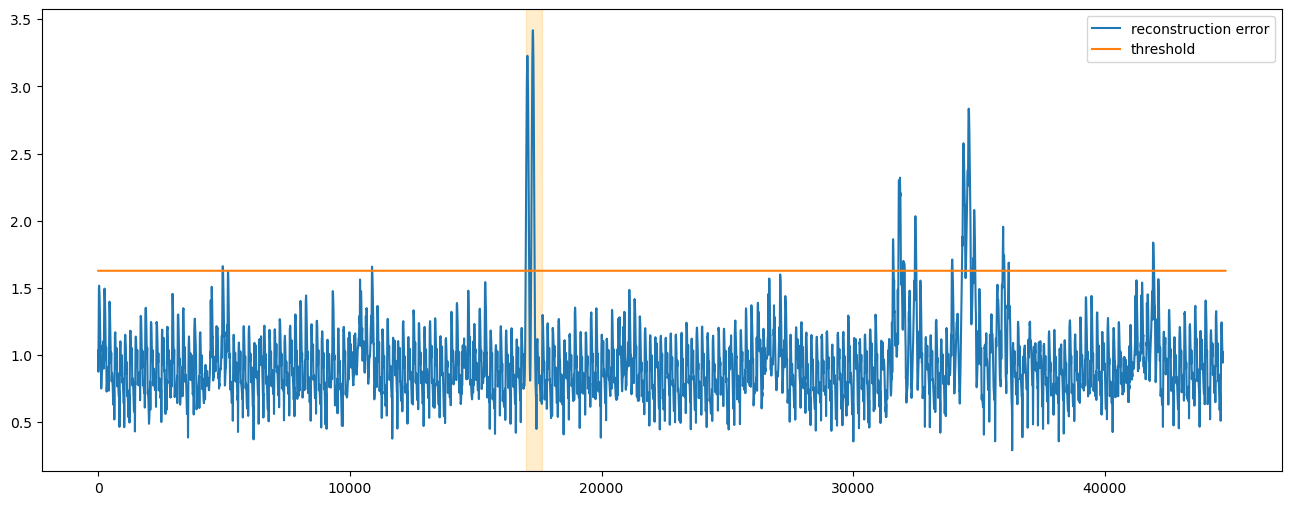

In [24]:
# Choose the lowest loss of the anomaly datas((# of anomalies)th) as threshold by using rank option
threshold = thresholds["rank"]
print(f"threshold: {threshold:.3f}")

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(111)

labels = df_test_label["label"].values.tolist()
dates = df_test.index


pd.DataFrame(np.sum(test_mae_loss, axis=1)).plot(ax=ax)
pd.DataFrame([threshold] * len(df_test)).plot(ax=ax)
ax.legend(["reconstruction error", "threshold"], loc="upper right")


temp_start = dates[0]
temp_date = dates[0]
temp_label = labels[0]

for xc, value in zip(dates, labels):
    if temp_label != value:
        if temp_label == True:
            ax.axvspan(temp_start, temp_date, alpha=0.2, color="orange")
        temp_start = xc
        temp_label = value
    temp_date = xc
if temp_label == True:
    ax.axvspan(temp_start, xc, alpha=0.2, color="orange")

## Predict & Evaluation


## #1 if any included time step has anomalies => abnormal

In [25]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalies = np.sum(test_mae_loss, axis=1) > threshold
print("Number of anomaly samples: ", np.sum(anomalies))

anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.any(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)
print("Number of anomalous samples: ", len(anomalous_data_indices))

test_pred = np.zeros(len(df_test))
test_label = df_test_label["label"]
test_pred[anomalous_data_indices] = 1

accuracy = (np.sum(test_pred == test_label)) / len(test_label)
precision = (np.sum(test_pred * test_label)) / np.sum(test_pred)
recall = (np.sum(test_pred * test_label)) / np.sum(test_label)
f1 = 2 * (precision * recall) / (precision + recall + 1e-7)

print(f"accuracy: {accuracy*100:.2f}%")
print(f"precision: {precision*100:.2f}%")
print(f"recall: {recall*100:.2f}%")
print(f"f1: {f1*100:.2f}%")

Number of anomaly samples:  1124
Number of anomalous samples:  2508
accuracy: 94.99%
precision: 17.62%
recall: 71.18%
f1: 28.25%


## #2 If half of included time steps has anomaly => abnormal

In [26]:
# data i is an anomaly if ratio of anomalies sequences/involved total sequences >= 0.5
anomalies = np.sum(test_mae_loss, axis=1) > threshold
test_anomalies = np.zeros(len(df_test))
test_seqs = np.zeros(len(df_test))
test_label = df_test_label["label"]
print("Number of anomaly samples: ", np.sum(anomalies))

for idx, anomaly in enumerate(anomalies):
    test_seqs[idx : min(idx + TIME_STEPS, len(df_test))] += 1
    if anomaly:
        test_anomalies[idx : min(idx + TIME_STEPS, len(df_test))] += 1
test_pred_ratio = np.divide(test_anomalies, test_seqs)
test_pred = test_pred_ratio >= 0.5
print("Number of anomalous samples: ", sum(test_pred))


accuracy = (np.sum(test_pred == test_label)) / len(test_label)
precision = (np.sum(test_pred * test_label)) / np.sum(test_pred)
recall = (np.sum(test_pred * test_label)) / np.sum(test_label)
f1 = 2 * (precision * recall) / (precision + recall + 1e-7)

print(f"accuracy: {accuracy*100:.2f}%")
print(f"precision: {precision*100:.2f}%")
print(f"recall: {recall*100:.2f}%")
print(f"f1: {f1*100:.2f}%")

Number of anomaly samples:  1124
Number of anomalous samples:  965
accuracy: 97.70%
precision: 28.70%
recall: 44.61%
f1: 34.93%


In [27]:
idx = 4690
evaluation_array = [(test_seqs - test_anomalies)[idx:idx+400],
                    test_anomalies[idx:idx+400],
                    test_seqs[idx:idx+400],
                    test_pred_ratio[idx:idx+400],
                    test_pred[idx:idx+400],
                    df_test_label["label"][idx:idx+400]]

df = pd.DataFrame(evaluation_array, dtype=float)
df.index = ['Normal', 'Anomaly', '#Seq', 'Pred(%)', 'Pred', 'GT']
df.style.background_gradient(cmap='summer', axis=1)

### #3 we could find the threshold with highest f1 score by calculating all cases 


In [28]:
from evaluator import evaluate

label = create_sequences(df_test_label["label"], TIME_STEPS)
print(label.shape)
scores = evaluate(x_test, x_test_pred, label, n=10, scoring="abs_mean")

(44696, 100)


In [29]:
# print("f1:",np.max(scores['f1']))
idx = np.argmax(scores["f1"])

print(f"threshold: {scores['thresholds'][idx]}")
print(f"precision: {scores['precision'][idx]*100:.2f}%")
print(f"recall: {scores['recall'][idx]*100:.2f}%")
print(f"f1: {scores['f1'][idx]*100:.2f}%")

threshold: 0.0
precision: 1.61%
recall: 100.00%
f1: 3.17%
